## Imports

In [7]:
from IPython.display import display, HTML
#display(HTML("<style>.container { width:55% !important; }</style>"))
#display(HTML("<style>.container { width:80% !important; }</style>"))
#display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.container { width:auto !important; }</style>"))

In [8]:
%matplotlib inline
import numpy as np
from scipy import special, optimize, stats
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

## Functions

In [9]:
# Convinience function
def get_BN_config_name(current_network_cfg, conf_name):
    bn_sting = "None"
    cfg_list = [str(x) for x in current_network_cfg[conf_name]]
    if np.array(['BN' in x or 'BN2d' in x or 'BN1d' in x for x in cfg_list]).any():
        # Contains BN's, lets check if these are noisy or non-noisy
        if np.array(['-NN' in x for x in cfg_list]).any():
            bn_sting = 'Non-noisy'
        else:
            bn_sting = 'Noisy'
    return bn_sting

# Fit functions
def logistic_cdf(x, mu, s, upper_limit_y=2., lower_limit_y=1., mirrored_x=False, log_x=False):
    """From: https://en.wikipedia.org/wiki/Logistic_distribution"""
    # Factor recalculation
    scale_y = upper_limit_y - lower_limit_y
    shift_y = lower_limit_y
    # Apply x changes
    if mirrored_x:
        x = -x
    if log_x:
        x = np.log10(x)
    # Calculate CDF
    cdf = 1 + np.exp(-(x-mu)/s)
    cdf = 1/cdf
    # Apply y changes
    y = cdf * scale_y + shift_y
    return y

available_cdfs = {
    'Logistic': logistic_cdf,
#     'Normal': normal_cdf,
}

## Data as produced by experiments

Note that this data is not exactly as returned by seml, but has been pre-processed, to extract the median and standard deviation of the final average validation accuracy over the last five epochs and multiple expeirments.

In [10]:
# Data properties
dataset_name, model_class_name = ('CIFAR10', 'LeNet')

current_network_cfg = {'LeNet5': ['C6@5',
  'ReLU',
  'M2',
  'C16@5',
  'ReLU',
  'M2',
  'Flatten',
  'FC120',
  'ReLU',
  'FC84',
  'ReLU'],
 'LeNet5-BN': ['C6@5',
  'BN2d',
  'ReLU',
  'M2',
  'C16@5',
  'BN2d',
  'ReLU',
  'M2',
  'Flatten',
  'FC120',
  'BN1d',
  'ReLU',
  'FC84',
  'BN1d',
  'ReLU'],
 'LeNet5-BN-noNoise': ['C6@5',
  'BN2d-NN',
  'ReLU',
  'M2',
  'C16@5',
  'BN2d-NN',
  'ReLU',
  'M2',
  'Flatten',
  'FC120',
  'BN1d-NN',
  'ReLU',
  'FC84',
  'BN1d-NN',
  'ReLU']}

sub_data_json = '{"_id":{"1123":1134,"1125":1136,"1127":1138,"1129":1140,"1131":1142,"1133":1144,"1135":1146,"1137":1148,"1139":1150,"1141":1152,"1143":1154,"1145":1156,"1147":1158,"1149":1160,"1151":1162,"1153":1164,"1155":1166,"1225":1236,"1227":1238,"1229":1240,"1231":1242,"1233":1244,"1235":1246,"1237":1248,"1239":1250,"1241":1252,"1243":1254,"1245":1256,"1247":1258,"1249":1260,"1251":1262,"1253":1264,"1255":1266,"1257":1268,"1327":1338,"1329":1340,"1331":1342,"1333":1344,"1335":1346,"1337":1348,"1339":1350,"1341":1352,"1343":1354,"1345":1356,"1347":1358,"1349":1360,"1351":1362,"1353":1364,"1355":1366,"1357":1368,"1359":1370,"1429":1440,"1431":1442,"1433":1444,"1435":1446,"1437":1448,"1439":1450,"1441":1452,"1443":1454,"1445":1456,"1447":1458,"1449":1460,"1451":1462,"1453":1464,"1455":1466,"1457":1468,"1459":1470,"1461":1472,"1531":1542,"1533":1544,"1535":1546,"1537":1548,"1539":1550,"1541":1552,"1543":1554,"1545":1556,"1547":1558,"1549":1560,"1551":1562,"1553":1564,"1555":1566,"1557":1568,"1559":1570,"1561":1572,"1563":1574,"1633":1644,"1635":1646,"1637":1648,"1639":1650,"1641":1652,"1643":1654,"1645":1656,"1647":1658,"1649":1660,"1651":1662,"1653":1664,"1655":1666,"1657":1668,"1659":1670,"1661":1672,"1663":1674,"1665":1676,"1735":1746,"1737":1748,"1739":1750,"1741":1752,"1743":1754,"1745":1756,"1747":1758,"1749":1760,"1751":1762,"1753":1764,"1755":1766,"1757":1768,"1759":1770,"1761":1772,"1763":1774,"1765":1776,"1767":1778,"1837":1848,"1839":1850,"1841":1852,"1843":1854,"1845":1856,"1847":1858,"1849":1860,"1851":1862,"1853":1864,"1855":1866,"1857":1868,"1859":1870,"1861":1872,"1863":1874,"1865":1876,"1867":1878,"1869":1880,"1939":1950,"1941":1952,"1943":1954,"1945":1956,"1947":1958,"1949":1960,"1951":1962,"1953":1964,"1955":1966,"1957":1968,"1959":1970,"1961":1972,"1963":1974,"1965":1976,"1967":1978,"1969":1980,"1971":1982,"2041":2052,"2043":2054,"2045":2056,"2047":2058,"2049":2060,"2051":2062,"2053":2064,"2055":2066,"2057":2068,"2059":2070,"2061":2072,"2063":2074,"2065":2076,"2067":2078,"2069":2080,"2071":2082,"2073":2084},"GaussStd":{"1123":0.01,"1125":0.0177827941,"1127":0.0316227766,"1129":0.0562341325,"1131":0.1,"1133":0.177827941,"1135":0.316227766,"1137":0.5623413252,"1139":1.0,"1141":1.77827941,"1143":3.1622776602,"1145":5.6234132519,"1147":10.0,"1149":17.7827941004,"1151":31.6227766017,"1153":56.234132519,"1155":100.0,"1225":0.01,"1227":0.0177827941,"1229":0.0316227766,"1231":0.0562341325,"1233":0.1,"1235":0.177827941,"1237":0.316227766,"1239":0.5623413252,"1241":1.0,"1243":1.77827941,"1245":3.1622776602,"1247":5.6234132519,"1249":10.0,"1251":17.7827941004,"1253":31.6227766017,"1255":56.234132519,"1257":100.0,"1327":0.01,"1329":0.0177827941,"1331":0.0316227766,"1333":0.0562341325,"1335":0.1,"1337":0.177827941,"1339":0.316227766,"1341":0.5623413252,"1343":1.0,"1345":1.77827941,"1347":3.1622776602,"1349":5.6234132519,"1351":10.0,"1353":17.7827941004,"1355":31.6227766017,"1357":56.234132519,"1359":100.0,"1429":0.01,"1431":0.0177827941,"1433":0.0316227766,"1435":0.0562341325,"1437":0.1,"1439":0.177827941,"1441":0.316227766,"1443":0.5623413252,"1445":1.0,"1447":1.77827941,"1449":3.1622776602,"1451":5.6234132519,"1453":10.0,"1455":17.7827941004,"1457":31.6227766017,"1459":56.234132519,"1461":100.0,"1531":0.01,"1533":0.0177827941,"1535":0.0316227766,"1537":0.0562341325,"1539":0.1,"1541":0.177827941,"1543":0.316227766,"1545":0.5623413252,"1547":1.0,"1549":1.77827941,"1551":3.1622776602,"1553":5.6234132519,"1555":10.0,"1557":17.7827941004,"1559":31.6227766017,"1561":56.234132519,"1563":100.0,"1633":0.01,"1635":0.0177827941,"1637":0.0316227766,"1639":0.0562341325,"1641":0.1,"1643":0.177827941,"1645":0.316227766,"1647":0.5623413252,"1649":1.0,"1651":1.77827941,"1653":3.1622776602,"1655":5.6234132519,"1657":10.0,"1659":17.7827941004,"1661":31.6227766017,"1663":56.234132519,"1665":100.0,"1735":0.01,"1737":0.0177827941,"1739":0.0316227766,"1741":0.0562341325,"1743":0.1,"1745":0.177827941,"1747":0.316227766,"1749":0.5623413252,"1751":1.0,"1753":1.77827941,"1755":3.1622776602,"1757":5.6234132519,"1759":10.0,"1761":17.7827941004,"1763":31.6227766017,"1765":56.234132519,"1767":100.0,"1837":0.01,"1839":0.0177827941,"1841":0.0316227766,"1843":0.0562341325,"1845":0.1,"1847":0.177827941,"1849":0.316227766,"1851":0.5623413252,"1853":1.0,"1855":1.77827941,"1857":3.1622776602,"1859":5.6234132519,"1861":10.0,"1863":17.7827941004,"1865":31.6227766017,"1867":56.234132519,"1869":100.0,"1939":0.01,"1941":0.0177827941,"1943":0.0316227766,"1945":0.0562341325,"1947":0.1,"1949":0.177827941,"1951":0.316227766,"1953":0.5623413252,"1955":1.0,"1957":1.77827941,"1959":3.1622776602,"1961":5.6234132519,"1963":10.0,"1965":17.7827941004,"1967":31.6227766017,"1969":56.234132519,"1971":100.0,"2041":0.01,"2043":0.0177827941,"2045":0.0316227766,"2047":0.0562341325,"2049":0.1,"2051":0.177827941,"2053":0.316227766,"2055":0.5623413252,"2057":1.0,"2059":1.77827941,"2061":3.1622776602,"2063":5.6234132519,"2065":10.0,"2067":17.7827941004,"2069":31.6227766017,"2071":56.234132519,"2073":100.0},"noise_type":{"1123":"GaussAdd","1125":"GaussAdd","1127":"GaussAdd","1129":"GaussAdd","1131":"GaussAdd","1133":"GaussAdd","1135":"GaussAdd","1137":"GaussAdd","1139":"GaussAdd","1141":"GaussAdd","1143":"GaussAdd","1145":"GaussAdd","1147":"GaussAdd","1149":"GaussAdd","1151":"GaussAdd","1153":"GaussAdd","1155":"GaussAdd","1225":"GaussAdd","1227":"GaussAdd","1229":"GaussAdd","1231":"GaussAdd","1233":"GaussAdd","1235":"GaussAdd","1237":"GaussAdd","1239":"GaussAdd","1241":"GaussAdd","1243":"GaussAdd","1245":"GaussAdd","1247":"GaussAdd","1249":"GaussAdd","1251":"GaussAdd","1253":"GaussAdd","1255":"GaussAdd","1257":"GaussAdd","1327":"GaussAdd","1329":"GaussAdd","1331":"GaussAdd","1333":"GaussAdd","1335":"GaussAdd","1337":"GaussAdd","1339":"GaussAdd","1341":"GaussAdd","1343":"GaussAdd","1345":"GaussAdd","1347":"GaussAdd","1349":"GaussAdd","1351":"GaussAdd","1353":"GaussAdd","1355":"GaussAdd","1357":"GaussAdd","1359":"GaussAdd","1429":"GaussAdd","1431":"GaussAdd","1433":"GaussAdd","1435":"GaussAdd","1437":"GaussAdd","1439":"GaussAdd","1441":"GaussAdd","1443":"GaussAdd","1445":"GaussAdd","1447":"GaussAdd","1449":"GaussAdd","1451":"GaussAdd","1453":"GaussAdd","1455":"GaussAdd","1457":"GaussAdd","1459":"GaussAdd","1461":"GaussAdd","1531":"GaussAdd","1533":"GaussAdd","1535":"GaussAdd","1537":"GaussAdd","1539":"GaussAdd","1541":"GaussAdd","1543":"GaussAdd","1545":"GaussAdd","1547":"GaussAdd","1549":"GaussAdd","1551":"GaussAdd","1553":"GaussAdd","1555":"GaussAdd","1557":"GaussAdd","1559":"GaussAdd","1561":"GaussAdd","1563":"GaussAdd","1633":"GaussAdd","1635":"GaussAdd","1637":"GaussAdd","1639":"GaussAdd","1641":"GaussAdd","1643":"GaussAdd","1645":"GaussAdd","1647":"GaussAdd","1649":"GaussAdd","1651":"GaussAdd","1653":"GaussAdd","1655":"GaussAdd","1657":"GaussAdd","1659":"GaussAdd","1661":"GaussAdd","1663":"GaussAdd","1665":"GaussAdd","1735":"GaussAdd","1737":"GaussAdd","1739":"GaussAdd","1741":"GaussAdd","1743":"GaussAdd","1745":"GaussAdd","1747":"GaussAdd","1749":"GaussAdd","1751":"GaussAdd","1753":"GaussAdd","1755":"GaussAdd","1757":"GaussAdd","1759":"GaussAdd","1761":"GaussAdd","1763":"GaussAdd","1765":"GaussAdd","1767":"GaussAdd","1837":"GaussAdd","1839":"GaussAdd","1841":"GaussAdd","1843":"GaussAdd","1845":"GaussAdd","1847":"GaussAdd","1849":"GaussAdd","1851":"GaussAdd","1853":"GaussAdd","1855":"GaussAdd","1857":"GaussAdd","1859":"GaussAdd","1861":"GaussAdd","1863":"GaussAdd","1865":"GaussAdd","1867":"GaussAdd","1869":"GaussAdd","1939":"GaussAdd","1941":"GaussAdd","1943":"GaussAdd","1945":"GaussAdd","1947":"GaussAdd","1949":"GaussAdd","1951":"GaussAdd","1953":"GaussAdd","1955":"GaussAdd","1957":"GaussAdd","1959":"GaussAdd","1961":"GaussAdd","1963":"GaussAdd","1965":"GaussAdd","1967":"GaussAdd","1969":"GaussAdd","1971":"GaussAdd","2041":"GaussAdd","2043":"GaussAdd","2045":"GaussAdd","2047":"GaussAdd","2049":"GaussAdd","2051":"GaussAdd","2053":"GaussAdd","2055":"GaussAdd","2057":"GaussAdd","2059":"GaussAdd","2061":"GaussAdd","2063":"GaussAdd","2065":"GaussAdd","2067":"GaussAdd","2069":"GaussAdd","2071":"GaussAdd","2073":"GaussAdd"},"enable_in_training":{"1123":1.0,"1125":1.0,"1127":1.0,"1129":1.0,"1131":1.0,"1133":1.0,"1135":1.0,"1137":1.0,"1139":1.0,"1141":1.0,"1143":1.0,"1145":1.0,"1147":1.0,"1149":1.0,"1151":1.0,"1153":1.0,"1155":1.0,"1225":1.0,"1227":1.0,"1229":1.0,"1231":1.0,"1233":1.0,"1235":1.0,"1237":1.0,"1239":1.0,"1241":1.0,"1243":1.0,"1245":1.0,"1247":1.0,"1249":1.0,"1251":1.0,"1253":1.0,"1255":1.0,"1257":1.0,"1327":1.0,"1329":1.0,"1331":1.0,"1333":1.0,"1335":1.0,"1337":1.0,"1339":1.0,"1341":1.0,"1343":1.0,"1345":1.0,"1347":1.0,"1349":1.0,"1351":1.0,"1353":1.0,"1355":1.0,"1357":1.0,"1359":1.0,"1429":1.0,"1431":1.0,"1433":1.0,"1435":1.0,"1437":1.0,"1439":1.0,"1441":1.0,"1443":1.0,"1445":1.0,"1447":1.0,"1449":1.0,"1451":1.0,"1453":1.0,"1455":1.0,"1457":1.0,"1459":1.0,"1461":1.0,"1531":1.0,"1533":1.0,"1535":1.0,"1537":1.0,"1539":1.0,"1541":1.0,"1543":1.0,"1545":1.0,"1547":1.0,"1549":1.0,"1551":1.0,"1553":1.0,"1555":1.0,"1557":1.0,"1559":1.0,"1561":1.0,"1563":1.0,"1633":1.0,"1635":1.0,"1637":1.0,"1639":1.0,"1641":1.0,"1643":1.0,"1645":1.0,"1647":1.0,"1649":1.0,"1651":1.0,"1653":1.0,"1655":1.0,"1657":1.0,"1659":1.0,"1661":1.0,"1663":1.0,"1665":1.0,"1735":1.0,"1737":1.0,"1739":1.0,"1741":1.0,"1743":1.0,"1745":1.0,"1747":1.0,"1749":1.0,"1751":1.0,"1753":1.0,"1755":1.0,"1757":1.0,"1759":1.0,"1761":1.0,"1763":1.0,"1765":1.0,"1767":1.0,"1837":1.0,"1839":1.0,"1841":1.0,"1843":1.0,"1845":1.0,"1847":1.0,"1849":1.0,"1851":1.0,"1853":1.0,"1855":1.0,"1857":1.0,"1859":1.0,"1861":1.0,"1863":1.0,"1865":1.0,"1867":1.0,"1869":1.0,"1939":1.0,"1941":1.0,"1943":1.0,"1945":1.0,"1947":1.0,"1949":1.0,"1951":1.0,"1953":1.0,"1955":1.0,"1957":1.0,"1959":1.0,"1961":1.0,"1963":1.0,"1965":1.0,"1967":1.0,"1969":1.0,"1971":1.0,"2041":1.0,"2043":1.0,"2045":1.0,"2047":1.0,"2049":1.0,"2051":1.0,"2053":1.0,"2055":1.0,"2057":1.0,"2059":1.0,"2061":1.0,"2063":1.0,"2065":1.0,"2067":1.0,"2069":1.0,"2071":1.0,"2073":1.0},"conf_name":{"1123":"LeNet5-BN-noNoise","1125":"LeNet5-BN-noNoise","1127":"LeNet5-BN-noNoise","1129":"LeNet5-BN-noNoise","1131":"LeNet5-BN-noNoise","1133":"LeNet5-BN-noNoise","1135":"LeNet5-BN-noNoise","1137":"LeNet5-BN-noNoise","1139":"LeNet5-BN-noNoise","1141":"LeNet5-BN-noNoise","1143":"LeNet5-BN-noNoise","1145":"LeNet5-BN-noNoise","1147":"LeNet5-BN-noNoise","1149":"LeNet5-BN-noNoise","1151":"LeNet5-BN-noNoise","1153":"LeNet5-BN-noNoise","1155":"LeNet5-BN-noNoise","1225":"LeNet5-BN-noNoise","1227":"LeNet5-BN-noNoise","1229":"LeNet5-BN-noNoise","1231":"LeNet5-BN-noNoise","1233":"LeNet5-BN-noNoise","1235":"LeNet5-BN-noNoise","1237":"LeNet5-BN-noNoise","1239":"LeNet5-BN-noNoise","1241":"LeNet5-BN-noNoise","1243":"LeNet5-BN-noNoise","1245":"LeNet5-BN-noNoise","1247":"LeNet5-BN-noNoise","1249":"LeNet5-BN-noNoise","1251":"LeNet5-BN-noNoise","1253":"LeNet5-BN-noNoise","1255":"LeNet5-BN-noNoise","1257":"LeNet5-BN-noNoise","1327":"LeNet5-BN-noNoise","1329":"LeNet5-BN-noNoise","1331":"LeNet5-BN-noNoise","1333":"LeNet5-BN-noNoise","1335":"LeNet5-BN-noNoise","1337":"LeNet5-BN-noNoise","1339":"LeNet5-BN-noNoise","1341":"LeNet5-BN-noNoise","1343":"LeNet5-BN-noNoise","1345":"LeNet5-BN-noNoise","1347":"LeNet5-BN-noNoise","1349":"LeNet5-BN-noNoise","1351":"LeNet5-BN-noNoise","1353":"LeNet5-BN-noNoise","1355":"LeNet5-BN-noNoise","1357":"LeNet5-BN-noNoise","1359":"LeNet5-BN-noNoise","1429":"LeNet5-BN-noNoise","1431":"LeNet5-BN-noNoise","1433":"LeNet5-BN-noNoise","1435":"LeNet5-BN-noNoise","1437":"LeNet5-BN-noNoise","1439":"LeNet5-BN-noNoise","1441":"LeNet5-BN-noNoise","1443":"LeNet5-BN-noNoise","1445":"LeNet5-BN-noNoise","1447":"LeNet5-BN-noNoise","1449":"LeNet5-BN-noNoise","1451":"LeNet5-BN-noNoise","1453":"LeNet5-BN-noNoise","1455":"LeNet5-BN-noNoise","1457":"LeNet5-BN-noNoise","1459":"LeNet5-BN-noNoise","1461":"LeNet5-BN-noNoise","1531":"LeNet5-BN-noNoise","1533":"LeNet5-BN-noNoise","1535":"LeNet5-BN-noNoise","1537":"LeNet5-BN-noNoise","1539":"LeNet5-BN-noNoise","1541":"LeNet5-BN-noNoise","1543":"LeNet5-BN-noNoise","1545":"LeNet5-BN-noNoise","1547":"LeNet5-BN-noNoise","1549":"LeNet5-BN-noNoise","1551":"LeNet5-BN-noNoise","1553":"LeNet5-BN-noNoise","1555":"LeNet5-BN-noNoise","1557":"LeNet5-BN-noNoise","1559":"LeNet5-BN-noNoise","1561":"LeNet5-BN-noNoise","1563":"LeNet5-BN-noNoise","1633":"LeNet5-BN-noNoise","1635":"LeNet5-BN-noNoise","1637":"LeNet5-BN-noNoise","1639":"LeNet5-BN-noNoise","1641":"LeNet5-BN-noNoise","1643":"LeNet5-BN-noNoise","1645":"LeNet5-BN-noNoise","1647":"LeNet5-BN-noNoise","1649":"LeNet5-BN-noNoise","1651":"LeNet5-BN-noNoise","1653":"LeNet5-BN-noNoise","1655":"LeNet5-BN-noNoise","1657":"LeNet5-BN-noNoise","1659":"LeNet5-BN-noNoise","1661":"LeNet5-BN-noNoise","1663":"LeNet5-BN-noNoise","1665":"LeNet5-BN-noNoise","1735":"LeNet5-BN-noNoise","1737":"LeNet5-BN-noNoise","1739":"LeNet5-BN-noNoise","1741":"LeNet5-BN-noNoise","1743":"LeNet5-BN-noNoise","1745":"LeNet5-BN-noNoise","1747":"LeNet5-BN-noNoise","1749":"LeNet5-BN-noNoise","1751":"LeNet5-BN-noNoise","1753":"LeNet5-BN-noNoise","1755":"LeNet5-BN-noNoise","1757":"LeNet5-BN-noNoise","1759":"LeNet5-BN-noNoise","1761":"LeNet5-BN-noNoise","1763":"LeNet5-BN-noNoise","1765":"LeNet5-BN-noNoise","1767":"LeNet5-BN-noNoise","1837":"LeNet5-BN-noNoise","1839":"LeNet5-BN-noNoise","1841":"LeNet5-BN-noNoise","1843":"LeNet5-BN-noNoise","1845":"LeNet5-BN-noNoise","1847":"LeNet5-BN-noNoise","1849":"LeNet5-BN-noNoise","1851":"LeNet5-BN-noNoise","1853":"LeNet5-BN-noNoise","1855":"LeNet5-BN-noNoise","1857":"LeNet5-BN-noNoise","1859":"LeNet5-BN-noNoise","1861":"LeNet5-BN-noNoise","1863":"LeNet5-BN-noNoise","1865":"LeNet5-BN-noNoise","1867":"LeNet5-BN-noNoise","1869":"LeNet5-BN-noNoise","1939":"LeNet5-BN-noNoise","1941":"LeNet5-BN-noNoise","1943":"LeNet5-BN-noNoise","1945":"LeNet5-BN-noNoise","1947":"LeNet5-BN-noNoise","1949":"LeNet5-BN-noNoise","1951":"LeNet5-BN-noNoise","1953":"LeNet5-BN-noNoise","1955":"LeNet5-BN-noNoise","1957":"LeNet5-BN-noNoise","1959":"LeNet5-BN-noNoise","1961":"LeNet5-BN-noNoise","1963":"LeNet5-BN-noNoise","1965":"LeNet5-BN-noNoise","1967":"LeNet5-BN-noNoise","1969":"LeNet5-BN-noNoise","1971":"LeNet5-BN-noNoise","2041":"LeNet5-BN-noNoise","2043":"LeNet5-BN-noNoise","2045":"LeNet5-BN-noNoise","2047":"LeNet5-BN-noNoise","2049":"LeNet5-BN-noNoise","2051":"LeNet5-BN-noNoise","2053":"LeNet5-BN-noNoise","2055":"LeNet5-BN-noNoise","2057":"LeNet5-BN-noNoise","2059":"LeNet5-BN-noNoise","2061":"LeNet5-BN-noNoise","2063":"LeNet5-BN-noNoise","2065":"LeNet5-BN-noNoise","2067":"LeNet5-BN-noNoise","2069":"LeNet5-BN-noNoise","2071":"LeNet5-BN-noNoise","2073":"LeNet5-BN-noNoise"},"weights_clamped":{"1123":false,"1125":false,"1127":false,"1129":false,"1131":false,"1133":false,"1135":false,"1137":false,"1139":false,"1141":false,"1143":false,"1145":false,"1147":false,"1149":false,"1151":false,"1153":false,"1155":false,"1225":false,"1227":false,"1229":false,"1231":false,"1233":false,"1235":false,"1237":false,"1239":false,"1241":false,"1243":false,"1245":false,"1247":false,"1249":false,"1251":false,"1253":false,"1255":false,"1257":false,"1327":false,"1329":false,"1331":false,"1333":false,"1335":false,"1337":false,"1339":false,"1341":false,"1343":false,"1345":false,"1347":false,"1349":false,"1351":false,"1353":false,"1355":false,"1357":false,"1359":false,"1429":false,"1431":false,"1433":false,"1435":false,"1437":false,"1439":false,"1441":false,"1443":false,"1445":false,"1447":false,"1449":false,"1451":false,"1453":false,"1455":false,"1457":false,"1459":false,"1461":false,"1531":false,"1533":false,"1535":false,"1537":false,"1539":false,"1541":false,"1543":false,"1545":false,"1547":false,"1549":false,"1551":false,"1553":false,"1555":false,"1557":false,"1559":false,"1561":false,"1563":false,"1633":false,"1635":false,"1637":false,"1639":false,"1641":false,"1643":false,"1645":false,"1647":false,"1649":false,"1651":false,"1653":false,"1655":false,"1657":false,"1659":false,"1661":false,"1663":false,"1665":false,"1735":false,"1737":false,"1739":false,"1741":false,"1743":false,"1745":false,"1747":false,"1749":false,"1751":false,"1753":false,"1755":false,"1757":false,"1759":false,"1761":false,"1763":false,"1765":false,"1767":false,"1837":false,"1839":false,"1841":false,"1843":false,"1845":false,"1847":false,"1849":false,"1851":false,"1853":false,"1855":false,"1857":false,"1859":false,"1861":false,"1863":false,"1865":false,"1867":false,"1869":false,"1939":false,"1941":false,"1943":false,"1945":false,"1947":false,"1949":false,"1951":false,"1953":false,"1955":false,"1957":false,"1959":false,"1961":false,"1963":false,"1965":false,"1967":false,"1969":false,"1971":false,"2041":false,"2043":false,"2045":false,"2047":false,"2049":false,"2051":false,"2053":false,"2055":false,"2057":false,"2059":false,"2061":false,"2063":false,"2065":false,"2067":false,"2069":false,"2071":false,"2073":false},"validation.accuracy":{"1123":76.42,"1125":76.972,"1127":76.228,"1129":76.394,"1131":75.574,"1133":73.764,"1135":70.814,"1137":65.918,"1139":56.9,"1141":44.562,"1143":32.296,"1145":23.304,"1147":14.666,"1149":10.138,"1151":10.146,"1153":10.108,"1155":10.35,"1225":76.876,"1227":77.042,"1229":76.106,"1231":76.53,"1233":74.978,"1235":73.064,"1237":70.554,"1239":65.808,"1241":56.132,"1243":43.996,"1245":32.34,"1247":22.966,"1249":11.782,"1251":10.046,"1253":10.17,"1255":10.066,"1257":10.0,"1327":76.336,"1329":76.396,"1331":75.972,"1333":75.516,"1335":75.912,"1337":73.446,"1339":70.588,"1341":65.812,"1343":57.108,"1345":44.054,"1347":32.472,"1349":23.388,"1351":13.906,"1353":9.982,"1355":10.122,"1357":10.066,"1359":9.842,"1429":76.472,"1431":76.982,"1433":75.558,"1435":76.442,"1437":75.602,"1439":73.426,"1441":72.46,"1443":65.028,"1445":56.816,"1447":44.794,"1449":32.794,"1451":23.414,"1453":15.086,"1455":9.956,"1457":9.786,"1459":10.202,"1461":9.972,"1531":76.408,"1533":76.094,"1535":76.35,"1537":75.326,"1539":75.216,"1541":74.026,"1543":71.668,"1545":67.004,"1547":56.268,"1549":43.898,"1551":32.372,"1553":22.766,"1555":14.634,"1557":10.162,"1559":10.086,"1561":9.984,"1563":10.018,"1633":76.526,"1635":76.196,"1637":75.666,"1639":76.034,"1641":74.788,"1643":74.398,"1645":70.998,"1647":66.366,"1649":56.296,"1651":44.348,"1653":32.054,"1655":22.86,"1657":11.658,"1659":10.222,"1661":10.032,"1663":10.26,"1665":10.056,"1735":76.468,"1737":76.428,"1739":76.61,"1741":75.728,"1743":74.736,"1745":73.292,"1747":70.53,"1749":65.36,"1751":56.626,"1753":44.016,"1755":32.32,"1757":23.412,"1759":15.388,"1761":10.156,"1763":9.906,"1765":9.95,"1767":10.068,"1837":76.928,"1839":76.514,"1841":76.6,"1843":76.022,"1845":75.566,"1847":74.188,"1849":71.198,"1851":64.778,"1853":56.458,"1855":44.26,"1857":32.104,"1859":22.874,"1861":13.662,"1863":9.956,"1865":9.95,"1867":10.062,"1869":10.184,"1939":76.812,"1941":76.652,"1943":76.568,"1945":74.944,"1947":75.558,"1949":74.734,"1951":71.922,"1953":66.446,"1955":56.932,"1957":44.734,"1959":32.242,"1961":22.958,"1963":14.926,"1965":10.296,"1967":10.086,"1969":10.186,"1971":10.068,"2041":76.174,"2043":76.32,"2045":75.852,"2047":75.364,"2049":74.226,"2051":72.652,"2053":71.792,"2055":66.616,"2057":56.716,"2059":44.376,"2061":32.592,"2063":22.834,"2065":12.826,"2067":9.998,"2069":10.006,"2071":10.096,"2073":9.962},"validation.accuracy_std":{"1123":0.1711139971,"1125":0.1289030644,"1127":0.0949526198,"1129":0.0523832034,"1131":0.1895890292,"1133":0.2289628791,"1135":0.3029587431,"1137":0.156639714,"1139":0.4201428329,"1141":0.2570136183,"1143":0.3954035913,"1145":0.1456845908,"1147":0.374625146,"1149":0.1787064632,"1151":0.1254750971,"1153":0.2134853625,"1155":0.2594609797,"1225":0.2190525051,"1227":0.1622837022,"1229":0.1281561547,"1231":0.1266491216,"1233":0.1322724461,"1235":0.1684755175,"1237":0.2901447914,"1239":0.2999599973,"1241":0.5124997561,"1243":0.3268394101,"1245":0.1344618905,"1247":0.2012560558,"1249":0.275637443,"1251":0.3782908934,"1253":0.3654038861,"1255":0.1845643519,"1257":0.3102901868,"1327":0.0861626369,"1329":0.0906862724,"1331":0.1034214678,"1333":0.1158619869,"1335":0.1285923792,"1337":0.0313687743,"1339":0.3792308004,"1341":0.2335294414,"1343":0.4199238026,"1345":0.3818690875,"1347":0.41527822,"1349":0.138477435,"1351":0.439754477,"1353":0.3277438024,"1355":0.4216823449,"1357":0.1909554922,"1359":0.124,"1429":0.1526302722,"1431":0.1197330364,"1433":0.1373171512,"1435":0.1301383879,"1437":0.1990376849,"1439":0.2882776439,"1441":0.3278414251,"1443":0.3038025675,"1445":0.3684888058,"1447":0.4835121508,"1449":0.2765935646,"1451":0.3307325203,"1453":0.2833090186,"1455":0.200059991,"1457":0.3207865334,"1459":0.1249639948,"1461":0.1727888885,"1531":0.1018626526,"1533":0.1257934815,"1535":0.1573531061,"1537":0.2638636011,"1539":0.210580151,"1541":0.0688767014,"1543":0.2947812748,"1545":0.159574434,"1547":0.2963376453,"1549":0.3778041821,"1551":0.3677716683,"1553":0.3237653471,"1555":0.2329463458,"1557":0.2012361796,"1559":0.4616752105,"1561":0.2473539973,"1563":0.1825814887,"1633":0.1204325537,"1635":0.1248358923,"1637":0.1867190403,"1639":0.05535341,"1641":0.1263962025,"1643":0.1554863338,"1645":0.2052705532,"1647":0.0708801806,"1649":0.1657226599,"1651":0.266338131,"1653":0.2592759148,"1655":0.4484640454,"1657":0.117541482,"1659":0.1689260193,"1661":0.1483778959,"1663":0.2409979253,"1665":0.3535873301,"1735":0.0994786409,"1737":0.1022545842,"1739":0.1109954954,"1741":0.1087014259,"1743":0.2289628791,"1745":0.2353210573,"1747":0.164924225,"1749":0.2756084179,"1751":0.2135040983,"1753":0.4213122358,"1755":0.5809302884,"1757":0.3443486605,"1759":0.271543735,"1761":0.2728809264,"1763":0.2708209741,"1765":0.153622915,"1767":0.1325745074,"1837":0.0549181209,"1839":0.0564269439,"1841":0.1302305648,"1843":0.0526877595,"1845":0.2840844945,"1847":0.2563123095,"1849":0.4178707934,"1851":0.4231973535,"1853":0.1672602762,"1855":0.2591524648,"1857":0.4496487518,"1859":0.2554681976,"1861":0.2735982456,"1863":0.2255304857,"1865":0.14,"1867":0.2155365398,"1869":0.4471957066,"1939":0.0299332591,"1941":0.160424437,"1943":0.1053375527,"1945":0.1364697769,"1947":0.1803773822,"1949":0.3759574444,"1951":0.3748813146,"1953":0.2083842604,"1955":0.3757339484,"1957":0.2270330372,"1959":0.4078921426,"1961":0.4187791781,"1963":0.2872350953,"1965":0.189377929,"1967":0.3342813187,"1969":0.2281753712,"1971":0.3716665172,"2041":0.0773563184,"2043":0.0675277721,"2045":0.1108873302,"2047":0.079649231,"2049":0.2519206224,"2051":0.259491811,"2053":0.2039019372,"2055":0.164632925,"2057":0.1402283851,"2059":0.3721075113,"2061":0.1971192532,"2063":0.4459417002,"2065":0.2989046671,"2067":0.1097998179,"2069":0.4182630751,"2071":0.2507269431,"2073":0.2488694437},"validation.loss":{"1123":53.8406757832,"1125":53.2559185266,"1127":55.3654174805,"1129":54.7837442338,"1131":55.1378632367,"1133":59.1849145412,"1135":66.656783545,"1137":77.4203465462,"1139":101.4613089442,"1141":159.5929335713,"1143":290.3100790977,"1145":556.0080103874,"1147":1113.4606807709,"1149":2159.7479927063,"1151":3832.4106582642,"1153":6841.6411865234,"1155":12053.4977844238,"1225":53.1432047367,"1227":53.0993232608,"1229":54.6996234775,"1231":53.8390533388,"1233":56.1767116427,"1235":60.9691427231,"1237":66.8947287083,"1239":76.9495895863,"1241":104.1720670581,"1243":161.2508743525,"1245":286.5303397655,"1247":560.9305480003,"1249":1178.4197221756,"1251":2168.278969574,"1253":3849.7445480347,"1255":6857.2116729736,"1257":12189.2224807739,"1327":54.2523387551,"1329":53.4907652199,"1331":54.3004284739,"1333":56.0755694389,"1335":55.7422402442,"1337":60.616317451,"1339":66.4001652658,"1341":77.4868627071,"1343":101.2890457034,"1345":159.9580429792,"1347":287.7239634514,"1349":555.1142613411,"1351":1139.1688446045,"1353":2177.3128578186,"1355":3836.0311805725,"1357":6857.5589645386,"1359":12141.5473373413,"1429":53.8234710276,"1431":53.7608641386,"1433":55.4681613326,"1435":54.2797421575,"1437":55.61297068,"1439":60.0134671032,"1441":62.5642352939,"1443":78.835598731,"1445":102.3579426765,"1447":158.2732895136,"1449":285.7916930199,"1451":553.2919602394,"1453":1110.1833511353,"1455":2170.7837158203,"1457":3860.5399085999,"1459":6833.9493911743,"1461":12148.388319397,"1531":54.3995851517,"1533":54.3487582803,"1535":54.1715376973,"1537":56.4419199884,"1539":56.8524545729,"1541":58.5550129473,"1543":64.2727913976,"1545":74.9112285256,"1547":102.9194173217,"1549":160.1870839357,"1551":287.2441577911,"1553":557.0258799076,"1555":1121.7814878464,"1557":2158.5382537842,"1559":3838.7474815369,"1561":6837.1355545044,"1563":12166.7262878418,"1633":53.7811957896,"1635":54.8286992371,"1637":55.682264185,"1639":54.9591027856,"1641":57.2816498756,"1643":58.6143141448,"1645":65.4782998919,"1647":75.7582117081,"1649":103.7700048923,"1651":159.4291699648,"1653":290.1193618059,"1655":559.122284317,"1657":1186.9682754517,"1659":2165.879668045,"1661":3835.6680480957,"1663":6833.986038208,"1665":12147.4778121948,"1735":54.1049272299,"1737":53.9842517197,"1739":54.3762701452,"1741":55.1677766144,"1743":56.2435259998,"1745":60.178363359,"1747":66.5453178763,"1749":78.9798289299,"1751":101.7968798161,"1753":160.2897177219,"1755":287.922086978,"1757":555.056297493,"1759":1110.7313760757,"1761":2162.3471347809,"1763":3861.4875770569,"1765":6854.0424194336,"1767":12123.2253967285,"1837":52.8058208764,"1839":53.8164567828,"1841":53.570994401,"1843":54.7929443955,"1845":56.3055434823,"1847":59.4243429661,"1849":64.5821191013,"1851":78.8749287367,"1853":102.5962359071,"1855":158.9202024937,"1857":291.0675731182,"1859":559.7207936287,"1861":1136.0092176437,"1863":2179.4712688446,"1865":3832.9262077332,"1867":6809.5296600342,"1869":12176.691960144,"1939":53.2913691103,"1941":53.9016196012,"1943":54.0167356849,"1945":57.0553978086,"1947":56.2845277071,"1949":57.5702470481,"1951":63.2604814947,"1953":76.6765892267,"1955":101.9846581221,"1957":157.8817965508,"1959":288.303691411,"1961":557.3203227997,"1963":1112.2897647858,"1965":2163.1659980774,"1967":3842.1755104065,"1969":6840.6355041504,"1971":12111.8357849121,"2041":54.8351360142,"2043":54.3892215788,"2045":55.1572705269,"2047":56.7508490086,"2049":59.182344687,"2051":62.01493752,"2053":64.2247128606,"2055":75.816206038,"2057":102.0224683523,"2059":159.4348686457,"2061":288.6088181496,"2063":560.3082684517,"2065":1155.3633665085,"2067":2158.5096492767,"2069":3838.2237678528,"2071":6838.3171203613,"2073":12173.8106948853},"validation.loss_std":{"1123":0.0725577627,"1125":0.0886169899,"1127":0.0806682804,"1129":0.0846362404,"1131":0.3034489621,"1133":0.1218990487,"1135":0.4319653362,"1137":0.3073396705,"1139":0.6850058594,"1141":2.9304199365,"1143":2.0973757364,"1145":4.0832501751,"1147":3.4946808985,"1149":17.3139394616,"1151":21.2469124781,"1153":26.1090708709,"1155":94.4441646281,"1225":0.1201595149,"1227":0.1109965728,"1229":0.1019775528,"1231":0.0942947433,"1233":0.1649603281,"1235":0.2700500058,"1237":0.1567734032,"1239":0.2751792203,"1241":0.6417814377,"1243":1.632359303,"1245":1.5646454659,"1247":4.5965391434,"1249":4.5908632743,"1251":13.3668611618,"1253":23.0105543684,"1255":9.8662025188,"1257":139.9065213546,"1327":0.1384061507,"1329":0.1086897234,"1331":0.1011058038,"1333":0.1315956473,"1335":0.2431004265,"1337":0.2838440219,"1339":0.3496024724,"1341":0.3642174695,"1343":0.4294721977,"1345":1.3414119277,"1347":1.3457285274,"1349":3.0605739537,"1351":9.131333138,"1353":13.0051629701,"1355":28.5507213459,"1357":57.5988219211,"1359":55.5889684734,"1429":0.0540805597,"1431":0.1126160819,"1433":0.1262543369,"1435":0.0958873262,"1437":0.1676479053,"1439":0.2351659998,"1441":0.2506640905,"1443":0.4160449628,"1445":0.8373251556,"1447":0.3803435682,"1449":1.6802125249,"1451":4.0183184437,"1453":7.5492443076,"1455":15.382423978,"1457":17.2854413474,"1459":14.6423656639,"1461":73.864258327,"1531":0.0948091721,"1533":0.2614945366,"1535":0.093723596,"1537":0.2903701881,"1539":0.2303234405,"1541":0.1537879277,"1543":0.309378757,"1545":0.4821169678,"1547":0.5209581711,"1549":1.472198725,"1551":2.4016164315,"1553":4.3614117403,"1555":7.4856271417,"1557":26.3715160689,"1559":50.6566553681,"1561":71.6030325998,"1563":48.77602586,"1633":0.0533486615,"1635":0.1626272707,"1637":0.1540247562,"1639":0.1684893499,"1641":0.1447179066,"1643":0.2910522367,"1645":0.1938523319,"1647":0.3636549905,"1649":0.4897314655,"1651":1.0074167101,"1653":1.9688534148,"1655":4.7756932724,"1657":11.7028102633,"1659":7.2846902792,"1661":7.4654812074,"1663":16.8854375114,"1665":44.3861796098,"1735":0.0899244677,"1737":0.0478709734,"1739":0.1721130818,"1741":0.162534821,"1743":0.2039200721,"1745":0.4676442286,"1747":0.3132420851,"1749":0.6823676685,"1751":0.8816435853,"1753":1.3193216394,"1755":2.0066527223,"1757":2.0951050517,"1759":7.6129551026,"1761":4.8049781219,"1763":28.3140611858,"1765":58.2707473303,"1767":80.5924139537,"1837":0.0828938216,"1839":0.0548330655,"1841":0.16837567,"1843":0.1752635865,"1845":0.2584841009,"1847":0.229082009,"1849":0.2950175543,"1851":0.5835106883,"1853":0.779108418,"1855":0.8717245839,"1857":2.049272745,"1859":3.0610406078,"1861":9.5728286014,"1863":8.2462045277,"1865":15.0484026732,"1867":59.3216249944,"1869":133.2366815748,"1939":0.0192507918,"1941":0.1225534257,"1943":0.1264957961,"1945":0.1491549643,"1947":0.2281902992,"1949":0.3393160054,"1951":0.2523540385,"1953":0.9325341691,"1955":0.9018723167,"1957":0.5919787357,"1959":2.791199355,"1961":1.9556338746,"1963":7.340898958,"1965":10.4882355675,"1967":23.9041397513,"1969":20.4338133813,"1971":56.3335953691,"2041":0.0744473725,"2043":0.1213810619,"2045":0.097290068,"2047":0.139816899,"2049":0.3174153844,"2051":0.3576379999,"2053":0.1476366035,"2055":0.4519133205,"2057":0.8474036638,"2059":0.2023334387,"2061":1.7358983443,"2063":4.0880682544,"2065":11.2159472669,"2067":11.1475112172,"2069":32.4502443772,"2071":49.2481105271,"2073":37.803393356}}'
sub_data = pd.read_json(sub_data_json)

n_type = 'GaussAdd'
conf_name = 'LeNet5-BN-noNoise'
enable_in_training = 1.0
weights_clamped = False

## Mid point noise calculation

In [11]:
# Fit properties
y_err_lower_limit = 0.75
bounds_wiggle_room = 0.5

Midpoint noise: 1.953 (± 3.7 %)


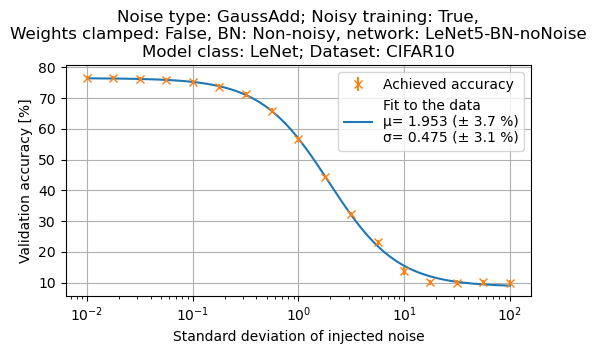

In [12]:
lines_plotted = []
#sub_data = data[(data['weights_clamped'] == weights_clamped) & (data['noise_type'] == n_type) & (data['enable_in_training'] == enable_in_training) & (data['conf_name'] == conf_name)]
if len(sub_data) == 0:
    pass
    #continue
noise_levels = np.asarray(sorted(list(set(sub_data['GaussStd']))))
plt.figure(figsize=(6, 4*0.75))
ax = plt.gca()
if "Add" in n_type:
    log_x = True
    ax.set_xscale('log')
else:
    log_x = False
for cdf_name in available_cdfs.keys():
    cdf = available_cdfs[cdf_name]
    y_data = []
    y_err = []
    for n_l in noise_levels:
        #sub_sub_data = data[(data['weights_clamped'] == weights_clamped) & (data['noise_type'] == n_type) & (data['enable_in_training'] == enable_in_training) & (data['GaussStd'] == n_l) & (data['conf_name'] == conf_name)]
        sub_sub_data = sub_data[((sub_data['GaussStd'] == n_l))]
        if 'GSC2' in dataset_name:
            y_data.append(sub_sub_data['test.accuracy'].mean())
            y_err.append(sub_sub_data['test.accuracy'].std())
        else:
            y_data.append(sub_sub_data['validation.accuracy'].mean())
            y_err.append(sub_sub_data['validation.accuracy'].std())
    y_data = np.array(y_data)
    if "Add" in n_type:
        x_data = noise_levels
    else:
        x_data = noise_levels * 100.
    # Calculate the half maximum point
    half_max = (y_data.max() - y_data.min())/2 + y_data.min()
    for first_lower_i in range(len(y_data)):
        if y_data[first_lower_i] < half_max:
            break
    lin_approx = np.polyfit(y_data[first_lower_i-1:first_lower_i+1], x_data[first_lower_i-1:first_lower_i+1], 1)
    lin_approx_fn = np.poly1d(lin_approx)
    x_half_max = lin_approx_fn(half_max)
    BN_name = get_BN_config_name(current_network_cfg, conf_name)

    # Set minimum error
    y_err = np.clip(y_err, y_err_lower_limit, np.inf)

    # Fitting
    # Set the fit bounds
    lower_rand_level = 10.
    if 'GSC2' in dataset_name:
        lower_rand_level = 100./12.
    p0_bounds = np.array((
        (-np.inf, np.inf),
        (-np.inf, np.inf),
        #(95., 100.),
        (y_data.max()-bounds_wiggle_room, y_data.max()+bounds_wiggle_room),
        (min(8., lower_rand_level-bounds_wiggle_room), lower_rand_level+bounds_wiggle_room),
    )).T
    # Wrap the cdf function to pass the log parameter externally
    if log_x:
        fit_x = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), 200)
        p0=np.array((np.log10(x_half_max), -0.15, y_data.max(), lower_rand_level))
    else:
        fit_x = np.linspace(x_data.min(), x_data.max(), 200)
        p0=np.array((x_half_max, -14., y_data.max(), lower_rand_level))
    fit_fun = lambda x, *p: cdf(x, *p, log_x=log_x)
    # Scipy Fit
    try:
        popt, pconv = optimize.curve_fit(fit_fun, x_data, y_data, sigma=y_err, absolute_sigma=True, p0=p0, bounds=p0_bounds)
    except RuntimeError:
        print(f"Fit for {cdf_name} CDF failed, continuing...")
        continue
    perr = np.sqrt(np.diag(pconv))

    # Chi2 calculation
    y_exp = fit_fun(x_data, *popt)
    chi2 = np.sum(np.square(y_exp - y_data) / np.square(y_err))
    chi2_red = chi2 / (len(y_data) - len(popt))

    # Plotting
    label_popt = deepcopy(popt)
    label_perr_rel = np.abs(100 * perr / popt)
    if log_x:
        label_popt = 10 ** label_popt
    label_popt = np.abs(label_popt)
    label = f'Fit to the data'
    label += f'\nµ= {label_popt[0]:.3f} (± {label_perr_rel[0]:.1f} %)'
    label += f'\nσ= {label_popt[1]:.3f} (± {label_perr_rel[1]:.1f} %)'
    #label += f'\ns= {label_popt[1]:.3f} (± {label_perr_rel[1]:.1f} %)'
    #label += f'\nchi2_red= {chi2_red:.2f}'
    plt.plot(fit_x, fit_fun(fit_x, *popt), label=label)
    print(f'Midpoint noise: {label_popt[0]:.3f} (± {label_perr_rel[0]:.1f} %)')


plt.errorbar(x_data, y_data, yerr=y_err, fmt='x', label=f"Achieved accuracy")

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

title = f"Noise type: {n_type}; Noisy training: {bool(enable_in_training)},\nWeights clamped: {weights_clamped}, BN: {BN_name}, network: {conf_name}"
title += f"\nModel class: {model_class_name}; Dataset: {dataset_name}"
plt.title(title)
plt.grid()
if 'GSC2' in dataset_name:
   plt.ylabel(f'Test accuracy [%]')
else:
   plt.ylabel(f'Validation accuracy [%]')
if "Add" in n_type:
    plt.xlabel('Standard deviation of injected noise')
else:
    plt.xlabel('Standard deviation of injected noise [%]')
plt.show()